# Single-pass BFT communication trees

## Problem
Get a potentially big message signed by a number of nodes in the shortest time, given a presence of byzantine nodes

## Narrowing down:
- There are 3f+1 nodes, with f byzantine nodes
- Timeouts are too costly
- The leader is doing its best
- Bandwidth and transmission delay is uniform over all nodes
- Missing network link between two nodes counts as one byzantine node
- The size of the reply is much smaller than the message itself

## Variables:
- X-axis variables:
    - f: # of byzantine nodes
    - T_d: time for the message to be processed by tree with depth ‘d’
- Components of x-axis variables:
    - N: # of nodes - N = 3 * f + 1
    - M: the size of the message
    - B: bandwidth of one node
    - P_d: transmission delay between two nodes, one-way
    - P_M: time to put the message on the network = M / B
    - N_n: # of nodes in level n of tree
- Y-axis, minimisation parameter
    - T: total time for one round-trip
- Optimization parameters:
    - D: depth of tree
    - C_n: maximum # of children for each node at tree-level n

## Generic T_d

 $$ T_d = 2 P_d (D-1) + P_M \sum_{i=0}^{d-2}\frac{C_i}{N_i} $$
 
This calculation ignores the verification time of the message.
But we suppose that the message is passed on from node to node before the message is verified.
So only the leaf-nodes verification time should be taken into account.
But because this is a constant over all experiements, we set it to 0.

# Special Cases

## ByzCoinX:
For ByzCoinX, the following optimisation parameters are used:
  $$ D = 3 $$

  $$ C_0 = N^{ \frac{1}{3} } $$

## Non-byzantine transmission time:
In the case where all nodes are correctly running, the C_n optimising T with a given D is:
$$ C_n = \ceil{ (N - 1) ^ \frac{1}{D - 1} } $$

# SP-Tree
We start the description of the single-pass tree without BFT sending and first look at a trivial case, then the generic case, before going to the BFT sending.

## Trivial Case - Broadcast
Taking the following parameters, which represent a broadcast from the leader, gives a trivial case that is easy to reason about:

-  `D = 2`, which means that:
-  `C_0 = N - 1`

It is optimal for the leader to broadcast the message to all nodes if 
  $$ T_2 < 4 P_d + 2 P_M $$
  
The right-hand term is the minimum delay for a tree with D > 2:
T must be bigger or equal to this term just for the network delay and the message transmission. 
So if the time to send the message to all nodes is smaller than this time, broadcasting is the most efficient protocol.

Given the following network parameters:
- `B = 1MBps`
- `P_d = 100ms`
The message-size at which a broadcast becomes not trivially optimal is:

$$ 2 P_d (D-1) + P_M \sum_{i=0}^{d-2}C_i / N_i < 4 P_d + 2 * P_M $$
$$ P_M C_0 + P_d < 4 P_d + 2 P_M $$
$$ P_M (N-1) < 3 P_d + 2 P_M $$
$$ P_M (N - 3) < 3 P_d $$
Given `P_M = M / B` and filling in our network parameters:
$$ M < 3 * P_d * B / (N - 3) < 3 * 0.1 * 1e6 / (N - 3) < 3e5 / (N - 3) $$

So for `f = 1, 2, 3, 4, 5`, the maximum M for which a broadcast is the fastest solution is
`M = 3e5, 8e4, 4e4, 2e4, 2e4`
Which means that for the current DEDIS-byzcoin testnet with 7 nodes and a mean block-size of 10kB, it would be optimal to use a broadcast protocol for most of the blocks.

## General, Non-Byzantine Case

If the message is bigger than the size given in the trivial case, we need to optimise `T_d` by searching for the optimal tree-depth `D`. 
Supposing that `C_n` is constant for all `n`s, we can write:

  $$ T_d = 2 P_d (D-1) + P_M \sum_{i=0}^{d-2}\frac{C_i}{N_i} $$
  
- Total number of nodes in a given level: `N_n` = `C ^ n`

  $$ 2 P_d (D-1) + P_M * \sum_{i=0}^{d-2}\frac{C}{C^i} $$
  $$ 2 P_d (D-1) + P_M * \sum_{i=0}^{d-2}C^{1-i} $$

- Number of children for each node `C_n` = `C` = `(N-1) ^ (1/(D-1))`

  $$ 2 P_d (D-1) + P_M * \sum_{i=0}^{d-2}(N-1)^{\frac{1-i}{D-1}} $$
  
The following code shows how this behaves with different time-delays due to the message transmission or the delay:

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt

import math
import numpy

def trivialC(N, d):
    return math.floor(math.pow(N-1, 1/(d-1)))

def trivialNi(N, d, i):
    if i <= 0:
        return 1
    
    tot = 1
    C = trivialC(N, d)
    Ni = 1
    for j in range(1, i+1):
        Ni *= C
        tot += Ni
        if tot >= N:
            if j == i:
                return N - (tot - Ni)
            else:
                return 0
                    
    return Ni

# Times are in ms
def trivial(d, PM = 1000, Pd = 100, N = 1000):
    t = 2 * Pd * (d-1)

    if d == 2:
        return t + PM * (N-1)
    
    if trivialNi(N, d, d-1) == 0:
        return trivial(d-1, PM, Pd, N)
        
    for i in range(d-1):
        Ni = trivialNi(N, d, i)
        Nip1 = trivialNi(N, d, i+1)
        t += PM * math.ceil(Nip1 / Ni)
        
    return t

if False:
    print(trivialC(10, 2))
    print(trivialC(10, 3))
    print(trivialC(10, 4))

    print()

    print(trivialNi(10, 4, 0))
    print(trivialNi(10, 4, 1))
    print(trivialNi(10, 4, 2))
    print(trivialNi(10, 4, 3))
    print(trivialNi(10, 4, 4))

    print()

    print(trivial(2))
    print(trivial(3))
    print(trivial(4))
    print(trivial(5))
    print(trivial(6))
    print(trivial(7))

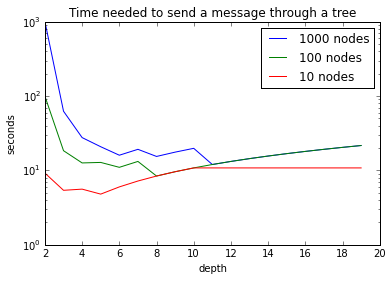

In [61]:
# Change the number of nodes

start = 2
end = 20
r = range(start,end)
f = [[0]*(end-start) for i in range(4)]

for d in r:
    f[0][d-start] = d
    f[1][d-start] = trivial(d, 1000, 100, 1000) / 1000
    f[2][d-start] = trivial(d, 1000, 100, 100) / 1000
    f[3][d-start] = trivial(d, 1000, 100, 10) / 1000

plt.figure(0)
plt.plot(f[0], f[1], label="1000 nodes")
plt.plot(f[0], f[2], label = "100 nodes")
plt.plot(f[0], f[3], label = "10 nodes")
plt.title('Time needed to send a message through a tree')
plt.ylabel('seconds')
plt.xlabel('depth')
plt.yscale('log')
_ = plt.legend()

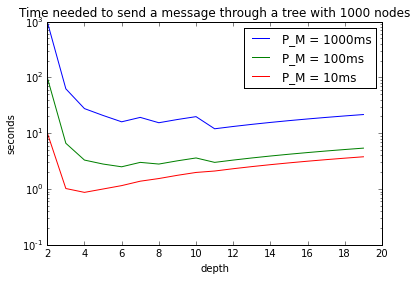

In [62]:
# Change the transmission time of the message

for d in r:
    f[0][d-start] = d
    f[1][d-start] = trivial(d, 1000) / 1000
    f[2][d-start] = trivial(d, 100) / 1000
    f[3][d-start] = trivial(d, 10) / 1000

plt.figure(1)
plt.plot(f[0], f[1], label="P_M = 1000ms")
plt.plot(f[0], f[2], label = "P_M = 100ms")
plt.plot(f[0], f[3], label = "P_M = 10ms")
plt.title('Time needed to send a message through a tree with 1000 nodes')
plt.ylabel('seconds')
plt.xlabel('depth')
plt.yscale('log')
_ = plt.legend()

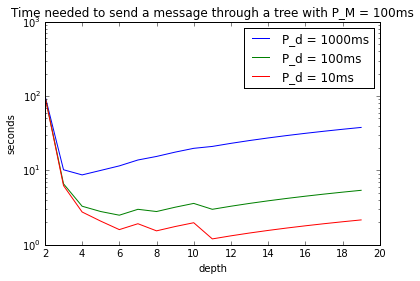

In [63]:
# Change the network delay

for d in r:
    f[0][d-start] = d
    f[1][d-start] = trivial(d, 100, 1000) / 1000
    f[2][d-start] = trivial(d, 100, 100) / 1000
    f[3][d-start] = trivial(d, 100, 10) / 1000

plt.figure(1)
plt.plot(f[0], f[1], label="P_d = 1000ms")
plt.plot(f[0], f[2], label = "P_d = 100ms")
plt.plot(f[0], f[3], label = "P_d = 10ms")
plt.title('Time needed to send a message through a tree with P_M = 100ms')
plt.ylabel('seconds')
plt.xlabel('depth')
plt.yscale('log')
_ = plt.legend()

## General Byzantine Case
The first approach to create a one-step general byzantine case is to let the leader contact `f+1` nodes. Each of these nodes has to contact `f+1` nodes itself, and the 3rd level of the tree does the same.
This assures that on each level `f` nodes can fail, but the protocol will still finish without the need to timeout and re-arrange the trees.
Of course this is very costly, so we can make two improvements:
### Only send block-id
We suppose that the block-size itself is very large (>1MB) with respect to the block-id (32B). This means that it's quite cheap to send the block-id to the nodes. So on every tree-level, each node only sends one block, but sends block-ids to the other `f` nodes.
For a non-failing network, this means that every node only has to send one block, and then only send block-ids to the other nodes. Only if a node doesn't receive a complete block will he have to contact the sender of the block-id for the complete block.
This breaks the assumption of no timeouts a little bit. But as we don't have to re-arrange the tree, and every node only has to watch out for itself, this should not be too difficult.
### Combine with optimal tree
The last optimization can be done for the leader: currently it has to contact all `f+1` nodes in the 2nd level of the tree. But we can do better:
Supposing that most of the time most of the nodes are OK, we can combine it with the optimal tree in the following manner: first the leader calculates the optimal tree, supposing no node will fail. Then the leader sends the blocks to the direct children, but sends only the block-id to the grand-children until it sent `f+1` messages in total.
This repeats for the whole tree, so that at the end every node receives either a block or a block-id. If the node only receives a block-id, but no block within a given time-interval, the node will request the block from the sender node of the block-id.
### Synchronous tree
If the blocks are created synchronously in a constant time-interval, then a node which didn't get the new block could simply request it from an alternative node, after having waited for the expected timeout.

## General, Byzantine Case - old

For the general byzantine case we suppose again that `C` is constant at every level of the tree.
Furthermore we don't want to retransmit, so all nodes must be able to receive a message.
This means that
  $$ C_n = C >= F + 1 $$
If `C` is smaller than `F + 1` and all the children of the root are failing, no node other than the root will verify the message.
We define the variable `R` so that `C = F + R`. `R` must be greater or equal to 1.
The allowed number of failing nodes is defined as: `F = (N - 1) / 3`

We build the tree in such a way that the list of nodes in every level has the following property:
- every node appears `f + 1` times to make sure he'll be contacted
- the nodes are spread out evenly over the level of the tree

If `R = 1`, `N_n` is the following:
```
N_0: `1`
N_1: `C = F + 1`
N_n: `floor{N_n-1 (F + 1) / (F + 1)} = N_n-1`
```
So for `R = 1`, every level of the tree can only accomodate `F+1` new nodes.

If `R = 2`, `N_n` is the following:
```
N_0: `1`
N_1: `C = F + 2`
N_n: `floor{N_n-1 (F + 2) / (F + 1)}`
```
As long as `floor{(F + 2) ^ 2 / (F + 1)} > F + 2`, every level of the tree will accomodate more and more nodes.

For a generic R, `C` and `N_n` take the following values:
```
C = F + R
N_0 = 1
N_n = floor{N_n-1 C / (F + 1)}
```

As the `floor` method is difficult to generalize, we now need an iterative process to find `D`:
`D` is the minimum number for which

  $$ \sum_{i=0}^{D}N_i >= N $$

Taking the generic formula of the time it takes to send a message to all nodes:

  $$ T_d = 2 P_d (D-1) + P_M \sum_{i=0}^{D-2}\frac{C_i}{N_i} $$
  
We can replace `C_i = C = F + R`

  $$ T_d = 2 P_d (D-1) + P_M \sum_{i=0}^{D-2}\frac{F + R}{N_i} $$

And `N_i = floor{ N_n-1 (F + R) / (F + 1) }` for `i > 0`. `N_0 = 1`, `N_1 = F + R`
  
  $$ T_d = 2 P_d (D-1) + P_M \sum_{i=0}^{D-2}\frac{F + R}{ \floor{ N_{n-1} \frac{F+R}{F+1}} } $$

The following code shows how this behaves with different time-delays due to the message transmission or the delay:

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt

import math
import numpy


def CalcF(N):
    return int((N-1) / 3)

def CalcNi(N, R, i):
    if i <= 0:
        return 1
    
    F = CalcF(N)
    Ni = F + R

    if i == 1:
        return min(N-1, Ni)
    
    if Ni >= N - 1:
        return 0
    
    tot = 1 + Ni
    for j in range(2, i+1):
        Ni = int(Ni * (F+R) / (F+1))
        tot += Ni
        if tot >= N:
            if j == i:
                return int(N - ( tot - Ni ))
            else:
                return 0
    
    return int(Ni)

def CalcD(N, R):
    sum = 0
    for d in range(100):
        sum += CalcNi(N, R, d)
        if sum >= N:
            return d + 1
        
    raise("Couldn't find depth for these parameters")

# Times are in ms
def complete(R, PM = 1000, Pd = 100, N = 1000):
    F = CalcF(N)
    C = F + R
    D = CalcD(N, R)
    t = 2 * Pd * (D-1)
    M = 1
    for i in range(D-1):
        Ni = CalcNi(N, R, i)
        Nip1 = CalcNi(N, R, i+1)
        Cp = math.ceil(Nip1 * M / Ni)
        t += PM * Cp
        M = F + 1
    
    return t

# Times are in ms
def fast(R, PM = 1000, Pd = 100, N = 1000):
    F = CalcF(N)
    C = F + R
    D = CalcD(N, R)
    t = 2 * Pd * (D-1)
    for i in range(D-1):
        Ni = CalcNi(N, R, i)
        Nip1 = CalcNi(N, R, i+1)
        Cp = math.ceil(Nip1 / Ni)
        t += PM * Cp
    
    return t

# Manual unit-testing...
#
#for n in range(10, 20):
#    print(F(n))
#

#for i in range(10):
#    print(Ni(100, 6, i))

#print(CalcD(100, 6))

#for r in range(1, 20, 5):
#    for n in range(20, 2000, 200):
#        print(n, r, D(n, r), Ni(n, r, 1), Ni(n, r, 2), Ni(n, r, 3))
#    print()

#print(Ni(100, 120, 0))
#print(Ni(100, 120, 1))
#print(Ni(100, 120, 2))

if False:
    for r in range(1, 120, 5):
        #print(r, CalcD(100, r), complete(r, 1000, 1000, 100))
        print(r, CalcD(100, r), CalcNi(100, r, 1), complete(r, 1000, 1000, 100))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] [46.6, 43.4, 42.4, 41.4, 41.4, 42.4, 43.4, 44.4, 46.4, 48.4, 49.2, 49.2, 49.2, 49.2, 49.2, 49.2, 49.2, 49.2, 49.2]


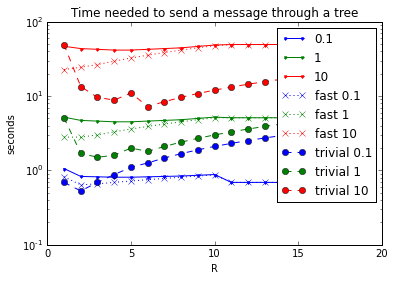

In [92]:
# Compare fully byzantine with plain

start = 1
end = 20
r = range(start,end)
f = [[0]*(end-start) for i in range(10)]
nodes = 50
pm0 = 10
pm1 = 100
pm2 = 1000
pd0 = 100
pd1 = 100
pd2 = 100

for d in r:
    f[0][d-start] = d
#    f[1][d-start] = trivial(d, 100, 1000, 100) / 1000
    dd = d * 3
    f[1][d-start] = complete(dd, pm0, pd0, nodes) / 1000
    f[2][d-start] = complete(dd, pm1, pd1, nodes) / 1000
    f[3][d-start] = complete(dd, pm2, pd2, nodes) / 1000

    f[4][d-start] = fast(dd, pm0, pd0, nodes) / 1000
    f[5][d-start] = fast(dd, pm1, pd1, nodes) / 1000
    f[6][d-start] = fast(dd, pm2, pd2, nodes) / 1000

    f[7][d-start] = trivial(d + 1, pm0, pd0, nodes) / 1000
    f[8][d-start] = trivial(d + 1, pm1, pd1, nodes) / 1000
    f[9][d-start] = trivial(d + 1, pm2, pd2, nodes) / 1000

print(f[0], f[3])
    
plt.figure(0)
plt.plot(f[0], f[1], "b.-", label="0.1")
plt.plot(f[0], f[2], "g.-", label="1")
plt.plot(f[0], f[3], "r.-", label="10")

plt.plot(f[0], f[4], "bx:", label="fast 0.1")
plt.plot(f[0], f[5], "gx:", label="fast 1")
plt.plot(f[0], f[6], "rx:", label="fast 10")

plt.plot(f[0], f[7], "bo--", label="trivial 0.1")
plt.plot(f[0], f[8], "go--", label="trivial 1")
plt.plot(f[0], f[9], "ro--", label="trivial 10")

plt.title('Time needed to send a message through a tree')
plt.ylabel('seconds')
plt.xlabel('R')
plt.yscale('log')
_ = plt.legend()

# Appendix
## Calculating Block Verification Time
The following calculation is very rough but gives an idea how long it takes to verify blocks of different sizes.
The current byzcoin-test network mainly gets blocks from test-routines which transfer coins in regular intervals.
Most of the blocks only contain 1 transaction, while some blocks contain up to 50 transactions.
Verifying a block means verifying all signatures and verifying the new state is correct.
- 100k blocks in 1GB of DB -> 10kB/block
- 100 minutes to check 100k blocks -> 6000s -> 16 blocks per second -> Verification of 160kBytes per second